In [1]:
import os
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from scipy.stats.mstats import gmean
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline
plt.rcParams['figure.figsize'] = [10.0, 6.0]

In [2]:
#import sys
#!{sys.executable} -m pip install seaborn-qqplot

# Loading intraday data

In [3]:
from iexfinance.stocks import get_historical_intraday
start = datetime(2020, 1, 1)
end = datetime.now()
ticker = 'AAPL'

path = f'{ticker}_intraday.pkl'
if os.path.exists(path):
    print(f"Loaded intraday data from {path}")
    intraday = pd.read_pickle(path)
else:
    os.environ['IEX_TOKEN'] = '<put key here>' # insert your API key
    dfs = []
    for dt in pd.date_range(start, end, freq='B'):
        print(f"Loading intraday data for {dt}")
        df = get_historical_intraday(ticker, dt, output_format='pandas')
        if len(df)>0:
            df = df.loc[:,['date','marketOpen','marketClose','marketVolume']]
            df.rename(columns={'marketOpen':'open', 'marketClose':'close', 'marketVolume':'volume'}, inplace=True)
            dfs.append(df)
    
    intraday = pd.concat(dfs)
    print(f"Saved intraday data to {path}")
    intraday.to_pickle(path)
    
intraday.head()

Loaded intraday data from AAPL_intraday.pkl


,date,open,close,volume
2020-01-02 09:30:00,2020-01-02,296.24,295.755,785402.0
2020-01-02 09:31:00,2020-01-02,295.70,295.530,201047.0
2020-01-02 09:32:00,2020-01-02,295.49,295.705,172261.0
2020-01-02 09:33:00,2020-01-02,295.71,296.550,295317.0
2020-01-02 09:34:00,2020-01-02,296.53,296.870,195182.0


Prepare daily aggregate and geometric moving average

In [4]:
daily = intraday.groupby('date').agg({'open': 'first', 'close': 'last', 'volume': 'sum'})
daily['gmav'] = daily.volume.rolling(20).agg(gmean).transform(np.ceil)
daily.tail()

,open,close,volume,gmav
date,,,,
2020-05-04,289.18,293.170,25662700.0,27712585.0
2020-05-05,295.06,297.780,28752517.0,27432351.0
2020-05-06,300.46,300.500,27768774.0,26971235.0
2020-05-07,303.22,303.750,21814655.0,26575761.0
2020-05-08,305.64,310.149,25083078.0,26310883.0


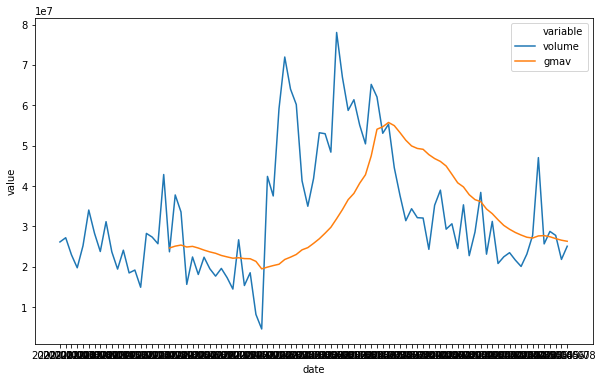

In [5]:
sns.lineplot(x='date', y='value', hue='variable', data=daily.loc[:,['volume','gmav']].reset_index().melt(id_vars=['date']))
plt.show()

# Fit lognorm dist
For some reason scipy fails to accurately fit lognorm to volume, so fitting norm to log volume

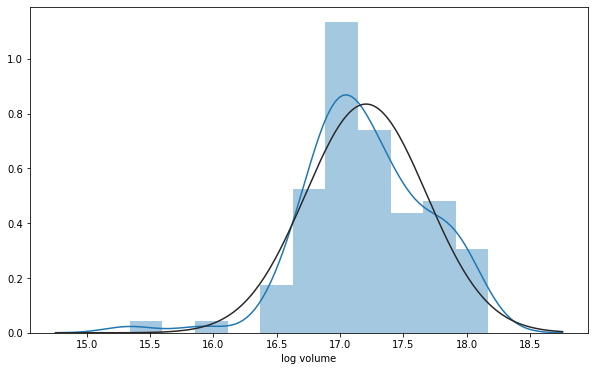

In [6]:
sns.distplot(np.log(daily.volume), fit=stats.norm, axlabel='log volume')
plt.show()

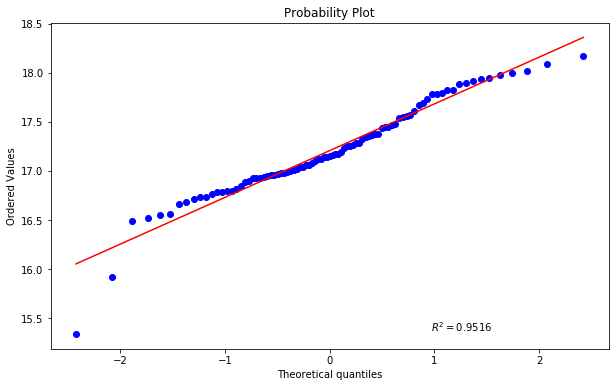

In [7]:
_ = stats.probplot(np.log(daily.volume), dist=stats.norm,  plot=plt, rvalue=True)

# Fitting gamma

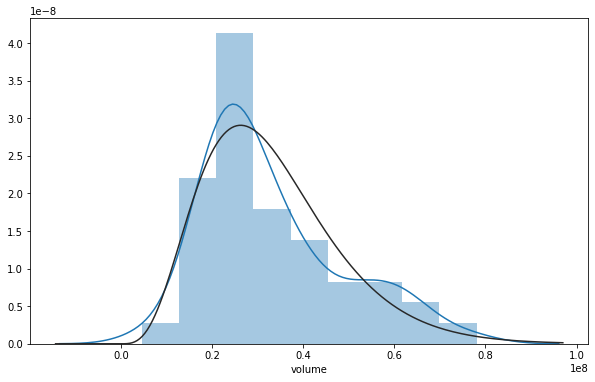

In [8]:
sns.distplot(daily.volume, fit=stats.gamma)
plt.show()

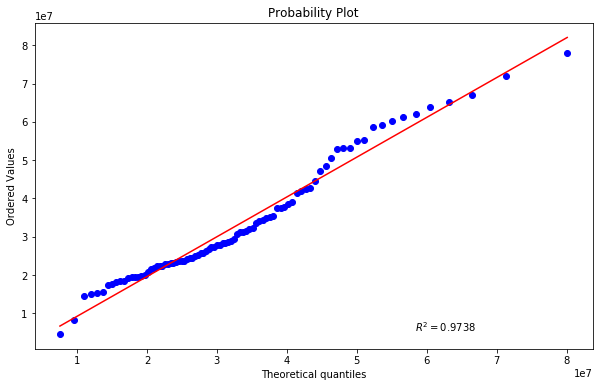

In [9]:
_ = stats.probplot(daily.volume, dist=stats.gamma, sparams=stats.gamma.fit(daily.volume), plot=plt, rvalue=True)